# Export Growth Prediction

## Model 1: Multivariate Linear Regression with Categorical Variable

Hypothesis:

$$(\log Ex - \overline{\log Ex_c}) =
\theta_{0} +
\theta_{1}(g_{GDP} - \overline{{g_{GDP}}_c}) +
\theta_{2}(\log GDP_{capita} - \overline{\log {GDP_{capita}}_c}) +
\theta_{3}(g_{im} - \overline{{g_{im}}_c}) + \epsilon.$$

where:  
* $Ex$ = export value of Taiwan
* $g_{GDP}$ = annual growth rate of real GDP of the importing country
* $GDP_{capita}$ = GDP per capita of the importing country
* $g_{im}$ = annual growth of import volume

and $\overline{\log Ex_c}$, $\overline{{g_{GDP}}_c}$, $\overline{\log {GDP_{capita}}_c}$, $\overline{{g_{im}}_c}$ are means of the respective values for country $c$ over all years. Also known as the fixed effects model.

### 1.1 Bad Practice vs. Standard Approach

* Bad:
    - Training: 1998-2013 (16 years)
    - Test: 2013
* Standard:
    - Training: 1997-2012 (16 years)
    - Test: 2013

#### Comparing Performance

#### Learning Curve: Are More Data Likely to Help?

### 1.2 Training with More Recent Data

- Training: 1997-2015 (19 years)
- Test: 2016

#### Evaluation

#### Error Analysis

#### Prediction

## Model 2: SVR Using Demeaned Variables

## Model 3: ARIMA

#### Scrape Monthly Export Data

In [1]:
import datetime
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
from io import StringIO
import pandas as pd
from functools import reduce

def get_mof_ts():
    
    current_year = datetime.datetime.now().year - 1911
    url = 'https://portal.sw.nat.gov.tw/APGA/GA06_csv'
    # Suppress InsecureRequestWarning
    requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

    def get_data(year):
        payload = {'searchInfo.StartYear': str(year),
                   'searchInfo.EndYear': '',
                   'searchInfo.StartMonth': '1',
                   'searchInfo.EndMonth': '12',
                   'searchInfo.TypeTime': '0',
                   'searchInfo.Type': 'MoneyUSD',
                   'searchInfo.CountryName': '全部國家合計,千里達,土耳其,土庫曼,大溪地,不丹,中非,中國大陸,丹麥,厄瓜多,厄利垂亞,巴布亞紐幾內亞,巴西,巴貝多,巴拉圭,巴林,巴哈馬,巴拿馬,巴勒斯坦,巴基斯坦,日本,比利時,牙買加,以色列,加拿大,加彭,北韓,卡達,古巴,史瓦濟蘭,尼日,尼加拉瓜,尼泊爾,布吉納法索,未列名法屬中美洲領域,未列名美屬中美洲領域,未列名美屬太平洋領域,未列名英屬中美洲領域,瓜地馬拉,甘比亞,白俄羅斯,立陶宛,伊拉克,伊朗,冰島,列支敦斯登,匈牙利,印尼,印度,吉布地,吉里巴斯,吉爾吉斯,吐瓦魯,多米尼克,多明尼加,多哥,安地卡,安圭拉,安哥拉,安道爾,衣索比亞,西班牙,西撒哈拉,克羅埃西亞,利比亞,宏都拉斯,希臘,沙烏地阿拉伯,汶萊,貝里斯,貝南,赤道幾內亞,辛巴威,亞美尼亞,亞塞拜然,其他大洋洲國家,其他中東及近東國家,其他中美洲國家,其他北美洲國家,其他亞洲國家,其他非洲國家,其他南美洲國家,其他國家,其他歐洲國家,坦尚尼亞,奈及利亞,委內瑞拉,孟加拉,尚比亞,帛琉,拉脫維亞,東加,波士尼亞赫塞哥維納,波札那,波多黎各,波蘭,法國,法屬圭亞那,肯亞,芬蘭,阿拉伯聯合大公國,阿根廷,阿曼,阿富汗,阿爾及利亞,阿爾巴尼亞,保加利亞,俄羅斯,南非,南韓,南蘇丹,哈薩克,柬埔寨,查德,玻利維亞,科威特,突尼西亞,約旦,美國,美屬薩摩亞,茅利塔尼亞伊斯蘭共和國,英國,迦納,香港,剛果,剛果民主共和國,哥倫比亞,哥斯大黎加,埃及,挪威,格陵蘭,格瑞那達,泰國,海地,烏干達,烏克蘭,烏拉圭,烏茲別克,琉球,秘魯,索馬利亞,索羅門群島,紐西蘭,納米比亞,納維斯,馬利,馬來西亞,馬其頓,馬拉威,馬約特,馬紹爾群島共和國,馬達加斯加,馬爾他,馬爾地夫,捷克,捷克,教廷,敘利亞,莫三比克,荷蘭,喀麥隆,喬治亞,幾內亞,幾內亞比索,斐濟,斯里蘭卡,斯洛伐克,斯洛維尼亞,智利,菲律賓,象牙海岸,越南,塞內加爾,塞席爾,塞爾維亞,塞爾維亞與蒙特內哥羅,塔吉克,奧地利,愛沙尼亞,愛爾蘭,新加坡,新克里多尼亞,獅子山,瑞士,瑞典,萬那杜,義大利,聖文森,聖多美普林西比,聖克里斯多福,聖馬利諾,聖露西亞,葉門,葛摩聯盟,葡萄牙,維德角,蒙古,蒙特內哥羅共和國,蒙瑟拉特,蒲隆地,蓋亞那,寮國,德國,摩洛哥,摩納哥,摩爾多瓦,模里西斯,緬甸,黎巴嫩,墨西哥,澳大利亞,澳門,盧安達,盧森堡,諾魯,賴比瑞亞,賴索托,賽普勒斯,薩伊,薩爾瓦多,薩摩亞,羅馬尼亞,關島,蘇丹,蘇利南,蘇聯',
                   'noData': 'false'}
        resp = requests.post(url, data=payload, verify=False)
        skiprows = None
        # For data after 2016, need to remove header "註：105年起按一般貿易制度編製。"
        if year >= 105:
            skiprows = 1
        # Get data in bytes, decode, and convert to dataframe
        df = pd.read_csv(StringIO(resp.content.decode(encoding='big5')), skiprows=skiprows)[
            ['日期', '國家', '出口總值']]
        return df

    df_map = map(lambda x: get_data(x), range(92, current_year + 1))
    df = reduce(lambda x, y: pd.concat([x, y], axis=0, ignore_index=True), df_map)

    # Parse into year and month
    df[['year', 'month']] = df['日期'].str.extract('(\d+)年(\d+)月', expand=False)
    # Create DatetimeIndex
    df.index = pd.to_datetime((df['year'].astype(int) + 1911).astype(str) + '-' + df['month'],
                              format='%Y-%m')
    df.index.name = 'date'
    # Keep only useful columns
    df = df[['國家', '出口總值']]
    df.columns = ['country', 'export']
    # Make wide dataframe
    df = pd.pivot_table(df, index=df.index, columns='country', values='export', fill_value=0)

    # Sum of newsouth eighteen and ten
    eighteen = ['不丹', '印尼', '印度', '孟加拉', '寮國', '尼泊爾', '巴基斯坦', '斯里蘭卡', '新加坡',
                '柬埔寨', '汶萊', '泰國', '澳大利亞', '紐西蘭', '緬甸', '菲律賓', '越南', '馬來西亞']
    ten = ['印尼', '寮國', '新加坡', '柬埔寨', '汶萊', '泰國', '緬甸', '菲律賓', '越南', '馬來西亞']
    df['十八國'] = df.loc[:, eighteen].sum(axis=1)
    df['十國'] = df.loc[:, ten].sum(axis=1)

    return df

ts = get_mof_ts()

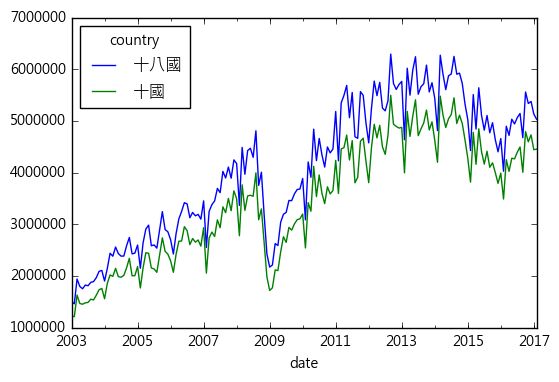

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.clf()
ts[['十八國', '十國']].plot()
plt.show()

## Model 4: Neural Network

## Model 5: Randomized Feature Selection

## Model 6: Averaging Ensemble

## Model 7: Stacking